# GAN for MIDI Rhythm Generation

preprocess midi data with `0_preprocess_midi.ipynb` in advance

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # only relevant to my own environment

## Constants

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]
MIDI_DRUM_MAP = {
   36: 0,
   35: 0,
   38: 1,
   27: 1,
   28: 1,
   31: 1,
   32: 1,
   33: 1,
   34: 1,
   37: 1,
   39: 1,
   40: 1,
   56: 1,
   65: 1,
   66: 1,
   75: 1,
   85: 1,
   42: 2,
   44: 2,
   54: 2,
   68: 2,
   69: 2,
   70: 2,
   71: 2,
   73: 2,
   78: 2,
   80: 2,
   46: 3,
   67: 3,
   72: 3,
   74: 3,
   79: 3,
   81: 3,
   45: 4,
   29: 4,
   41: 4,
   61: 4,
   64: 4,
   84: 4,
   48: 5,
   47: 5,
   60: 5,
   63: 5,
   77: 5,
   86: 5,
   87: 5,
   50: 6,
   30: 6,
   43: 6,
   62: 6,
   76: 6,
   83: 6,
   49: 7,
   55: 7,
   57: 7,
   58: 7,
   51: 8,
   52: 8,
   53: 8,
   59: 8,
   82: 8
}

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Training

In [3]:
import numpy as np

# # load pianoroll matrix - see "0_preprocess_midi.ipynb"

# matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
# matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
# GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

# print(GENRES_ALL)
# print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# NB_GENRES = len(GENRES)

# print(GENRES_ID_USED)
# print(NB_GENRES, GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)


In [4]:
import numpy as np

# make sure you have run "0_preprocess_midi.ipynb" in advance
matrices_drums = np.load("./tmp/matrices_drum_groove_genres.npz")['onsets']
matrices_velocities = np.load("./tmp/matrices_drum_groove_genres.npz")['velocities']
matrices_offsets = np.load("./tmp/matrices_drum_groove_genres.npz")['timeshifts']
matrices_genres = np.load("./tmp/matrices_drum_groove_genres.npz")['genre_ids']
GENRES = np.load("./tmp/matrices_drum_groove_genres.npz")['genres']

NB_GENRES = len(GENRES)
print(GENRES)
print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# NB_GENRES = len(GENRES)

# print(GENRES_ID_USED)
# print(NB_GENRES, GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)


['latin' 'jazz' 'soul' 'hiphop' 'rock' 'funk']
(16657,)


In [5]:
def wasserstein_loss(y_true, y_pred):
    return -K.mean(y_true * y_pred)

## Discriminator

In [6]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional
from keras.layers import Embedding, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential


# # encoder
# drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order

# x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
# x = Bidirectional(LSTM(64, return_sequences=False, activation='tanh'))(x)
# x = Dense(256)(x)
# x = LeakyReLU(alpha=0.01)(x)
# output = Dense(1)(x)

# discriminator = Model(drum_input, output)
# discriminator.summary()

# optimizer = RMSprop ( lr = 0.0008 )  # higher leraning rate for D
# discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', 
#                       metrics=['accuracy'])

import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM
from keras.layers import Bidirectional, Lambda, Concatenate, Softmax, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.models import Model
from keras import regularizers

droprate = 0.4

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
# offset_input = Input(shape=(len_seq, nb_notes), name='offset_input')  # tensorflow order

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(drum_input) 
#x0 = BatchNormalization()(x0)
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x0)
#x0 = BatchNormalization()(x0)
#x0 = Dropout(droprate)(x0)

x = Flatten()(x)

# x1 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(offset_input) 
# x1 = BatchNormalization()(x1)
# x1 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x1)
# x1 = BatchNormalization()(x1)
# #x1 = Dropout(droprate)(x1)

# x = Concatenate(axis=-1)([x0, x1])
#x = Dropout(droprate)(x0)
#x = LeakyReLU(alpha=0.01)(x)
x = Dense(512, activation='sigmoid')(x)
output = Dense(1, activation=None)(x)
#output = LeakyReLU(alpha=0.01)(x)

discriminator = Model(drum_input, output)
discriminator.summary()

optimizer = RMSprop ( lr = 0.00005 )  # higher leraning rate for D
discriminator.compile(optimizer=optimizer, loss=wasserstein_loss, 
                      metrics=['accuracy'])

Using TensorFlow backend.
W1129 12:59:46.060204 140215157856000 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1129 12:59:46.069303 140215157856000 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1129 12:59:46.071274 140215157856000 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1129 12:59:46.168083 140215157856000 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
drum_input (InputLayer)      (None, 32, 9)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 256)           141312    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32, 256)           394240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 4,730,881
Trainable params: 4,730,881
Non-trainable params: 0
_________________________________________________________________


## GENERATOR 

In [7]:
from keras.layers import Reshape, Conv2DTranspose, RepeatVector, Activation,Bidirectional,multiply
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D

len_input = 256

z_input = Input(shape=(len_input,))  # tensorflow order

# x = Dense(512)(z_input)
# x = LeakyReLU(alpha=0.2)(x)
# x = BatchNormalization(momentum=0.9)(x)
x = Dense(1024)(z_input)
x = LeakyReLU(alpha=0.2)(x)
#x = BatchNormalization(momentum=0.9)(x)
x = Reshape((32, 32))(x)

x = LSTM(512, return_sequences=True, activation='tanh')(x) 
x = LSTM(512, return_sequences=True, activation='tanh')(x)
note_out = LSTM(9, return_sequences=True, activation='sigmoid')(x)
# output = LeakyReLU()(x)

generator = Model(z_input, note_out)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 512)           1116160   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 512)           2099200   
_________________________________________________________________
lstm_5 (LSTM)                (None, 32, 9)             18792     
Total para

## ADVERSARIAL MODEL 

In [8]:

from keras.models import Sequential


# define input for the combined GAN model
z_input = Input(shape=(len_input,))  # tensorflow order
img_gan = generator(z_input)

# training is disable for discriminator in adversarial model
discriminator.trainable = False 

# define output
prediction_gan = discriminator(img_gan)

# define combined GAN model
gan = Model(z_input, prediction_gan)

optimizer = RMSprop ( lr = 0.00005 )
gan.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 9)             3497320   
_________________________________________________________________
model_1 (Model)              (None, 1)                 4730881   
Total params: 8,228,201
Trainable params: 3,497,320
Non-trainable params: 4,730,881
_________________________________________________________________


In [9]:
print(gan.metrics_names)
print (discriminator.metrics_names)


['loss', 'acc']
['loss', 'acc']


## Training

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import random
import pretty_midi
from IPython.display import Audio
from scipy.io import wavfile

# Create Z for generator
def get_noise(batch_size, len_input):
#    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, len_input])
    
    # better to use a spherical Z. according to https://github.com/soumith/ganhacks
    noise = np.random.normal(0.0, 1.0, size=[batch_size, len_input])
    return noise

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  
        
        import pretty_midi

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data

In [11]:
from tensorboard_logger import configure, log_value

from datetime import datetime
now = datetime.now()
logdir_prefix = "/tmp/tf_logs_gan/"
logdir = logdir_prefix + now.strftime("%Y%m%d-%H%M%S") 
cmd = "tensorboard --logdir=" + logdir_prefix
print (cmd)

configure(logdir, flush_secs=5)

tensorboard --logdir=/tmp/tf_logs_gan/


## Test

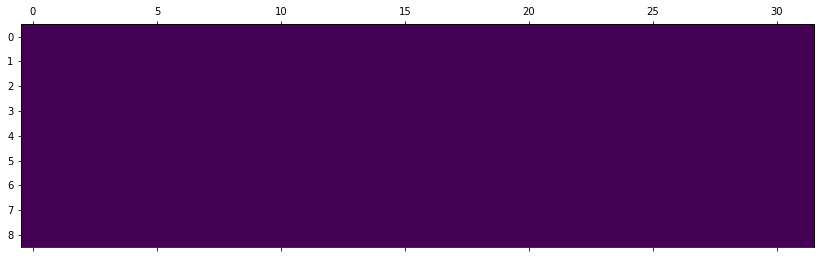

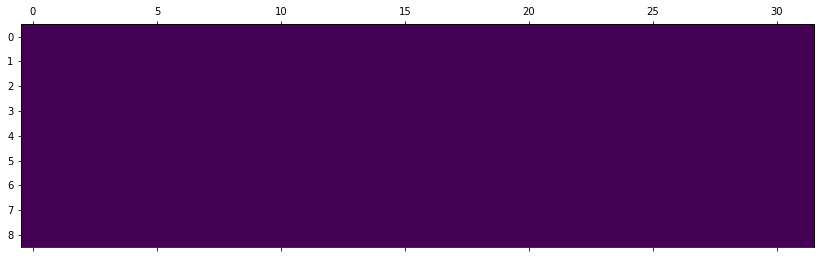

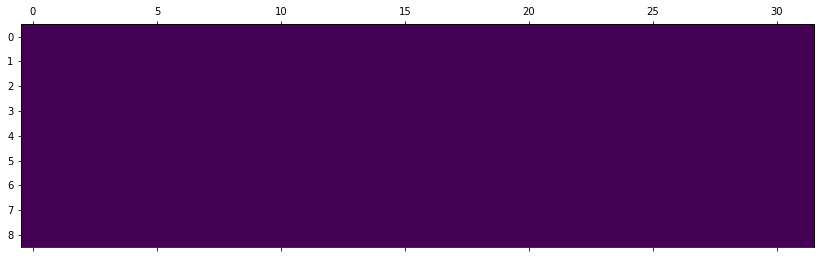

In [12]:
for i in range(3):
    noise = get_noise(1, len_input)
    drum_generated = generator.predict(noise)
    plot_drum_matrix(drum_generated)